In [1]:
%run "../HyperParameterOpt/GenerateExperiments/res_experiment.py"
import copy
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity

DIFF_EQ_PARAMS = {
                  "x0": [-20, 10, -.5],
                  "begin": 0,
                  "end": 85,
                  "timesteps": 85000,
                  "train_per": .889,
                  "solver": lorenz_equ,
                  "clip": 40
                 }

RES_PARAMS = {
              "uniform_weights": True,
              "solver": "ridge",
              "ridge_alpha": 1e-6,
              "signal_dim": 3,
              "network": "random graph",

              "res_sz": 15,
              "activ_f": np.tanh,
              "connect_p": .1,
              "spect_rad": 5,
              "gamma": 5,
              "sigma": .14,
              "sparse_res": True,
             }

TOL = 5

In [2]:
def adj_matrix(topology, topo_params, n, remove_p=0):
    adj = generate_adj(topology, topo_params, n)
    adj = remove_edges(adj, floor(remove_p*np.sum(adj != 0)))
    return adj

def res_acc(rc, u, test_t):
    pre = rc.predict(test_t)
    return how_long_accurate(u(test_t), pre, tol=TOL)

def train_rc(adj, diff_eq_params, res_params):
    diff_eq_params["x0"] = random_lorenz_x0()
    train_t, test_t, u = rc_solve_ode(diff_eq_params)
    rc = ResComp(adj, **res_params)
    rc.fit(train_t, u)
    r0 = rc.state_0
    return rc, r0, res_acc(rc, u, test_t)

def effective_adj(rc):
    return rc.res + rc.sigma * rc.W_in @ rc.W_out

def W_out_kde(rc):
    kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
    kde.fit(rc.W_out.ravel().reshape(-1,1))
    return kde

def random_W_out(rc):
    old_W_out = np.copy(rc.W_out)
    kde = W_out_kde(rc)
    rand_W_out = kde.sample(rc.W_out.shape)
    rc.W_out = rand_W_out.reshape(rc.W_out.shape)
    return rc, old_W_out

## Undriven Small RC


# $ \frac{d}{dt}\mathbf{r}(t) = \gamma[\, -\mathbf{r}(t) + \text{tanh}\big(\mathbf{A}\mathbf{r}(t) \big) \,]$


In [3]:
rc = ResComp(**RES_PARAMS)
train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)

def zerof(x):
    if type(x) is float:
        return np.zeros(rc.signal_dim)
    else:
        return np.zeros((rc.signal_dim, len(x)))
    
err, states = rc.fit(train_t, zerof, return_states=True)

### All Node States

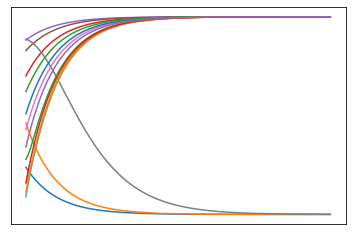

In [4]:
plt.plot(states[:2000,:])
plt.xticks([])
plt.yticks([])
plt.show()

### Single Node States

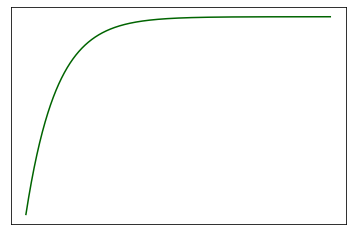

In [5]:
plt.plot(states[:2000,6], c="darkgreen")
plt.xticks([])
plt.yticks([])
plt.show()

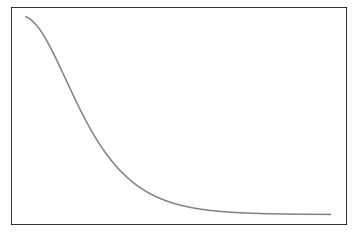

In [6]:
plt.plot(states[:2000,7], c="grey")
plt.xticks([])
plt.yticks([])
plt.show()

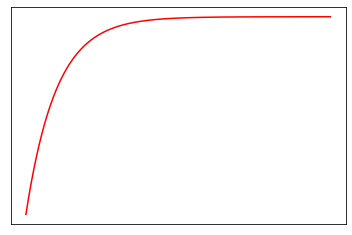

In [7]:
plt.plot(states[:2000,9], c="r")
plt.xticks([])
plt.yticks([])
plt.show()

## Driven Small RC

# $ \frac{d}{dt}\mathbf{r}(t) = \gamma[\, -\mathbf{r}(t) + \text{tanh}\big(\mathbf{A}\mathbf{r}(t) + \sigma \mathbf{W}_{\text{in}}\mathbf{u}(t)\big) \,]$


In [8]:
rc = ResComp(**RES_PARAMS)
train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)
err, states = rc.fit(train_t, u, return_states=True)

## Driving Signal

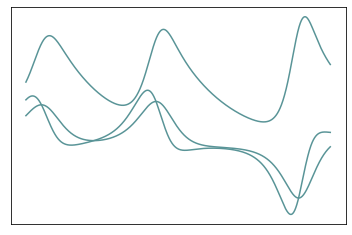

In [9]:

plt.plot(u(train_t[:2000]).T, c=[0.3501571,  0.58115139, 0.59028975])
plt.xticks([])
plt.yticks([])
plt.show()

### All Node States

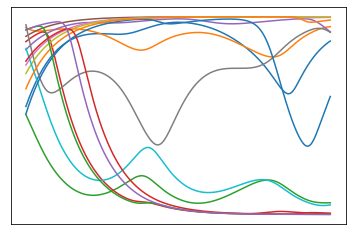

In [10]:
plt.plot(states[:2000,:])
plt.xticks([])
plt.yticks([])
plt.show()

### Single Node States

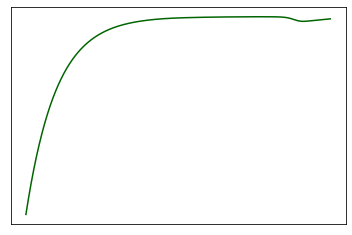

In [11]:
plt.plot(states[:2000,6], c="darkgreen")
plt.xticks([])
plt.yticks([])
plt.show()

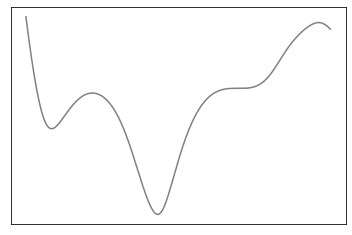

In [12]:
plt.plot(states[:2000,7], c="grey")
plt.xticks([])
plt.yticks([])
plt.show()

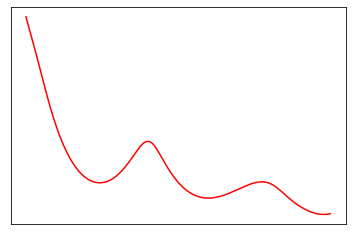

In [13]:
plt.plot(states[:2000,9], c="r")
plt.xticks([])
plt.yticks([])
plt.show()

# Predicted Signal

# $\frac{d}{dt}\mathbf{r}(t) = \gamma[-\mathbf{r}(t) + \text{tanh}\big(\mathbf{A}\mathbf{r}(t) + \sigma \mathbf{W}_{\text{in}}\mathbf{W}_{\text{out}}\mathbf{r}(t)\big)$

# $\hat{\mathbf{u}}(t) = \mathbf{W}_{\text{out}}\mathbf{r}(t)$

In [14]:
uhat, states = rc.predict(test_t, return_states=True)

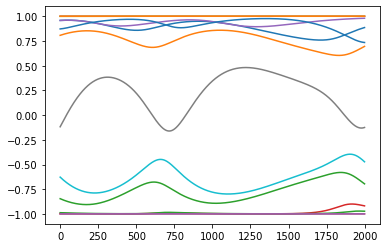

In [15]:
plt.plot(states[:,:2000].T)
plt.show()

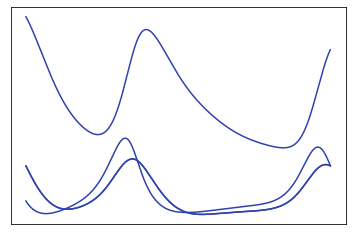

In [26]:
color = [0.17861669, 0.25868885, 0.67362692]
plt.plot(uhat[0,:2000].T, c=color)
plt.plot(uhat[:,:2000].T, c=color)
plt.xticks([])
plt.yticks([])
plt.show()

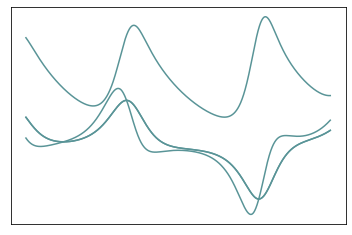

In [32]:
color = [0.17861669, 0.25868885, 0.67362692]
plt.plot(u(test_t[:2000])[0,:].T, c=[0.3501571,  0.58115139, 0.59028975], label="$\mathbf{u}(t)$")
plt.plot(u(test_t[:2000]).T, c=[0.3501571,  0.58115139, 0.59028975])

plt.xticks([])
plt.yticks([])
plt.show()

# We solve for $\mathbf{W}_{\text{out}}$ so

# $\hat{u}(t)$ approximates $u(t)$

[0.17861669, 0.25868885, 0.67362692]


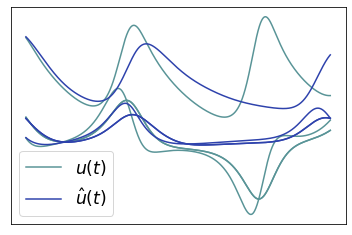

In [34]:
color = [0.17861669, 0.25868885, 0.67362692]
print(color)
plt.plot(u(test_t[:2000])[0,:].T, c=[0.3501571,  0.58115139, 0.59028975], label="$u(t)$")
plt.plot(u(test_t[:2000]).T, c=[0.3501571,  0.58115139, 0.59028975])

plt.plot(uhat[0,:2000].T, c=color, label="$\hat{u}(t)$")
plt.plot(uhat[:,:2000].T, c=color)

plt.xticks([])
plt.yticks([])
plt.legend(fontsize="xx-large")
plt.show()

Generate 10 Adj for Dr. Webb

Fourier Analysis

Phase locking